`Adaptive Transformers for Learning Multimodal Representations`\
Vision-and-language reasoning requires an understanding of visual concepts, language semantics, and, most importantly, the alignment and relationships between these two modalities. We thus propose the LXMERT (Learning Cross-Modality Encoder Representations from Transformers) framework to learn these vision-and-language connections. In LXMERT, we build a large-scale Transformer model that consists of three encoders: an object relationship encoder, a language encoder, and a cross-modality encoder. Next, to endow our model with the capability of connecting vision and language semantics, we used pre-trained the model with large amounts of image-and-sentence pairs, via five diverse representative pre-training tasks: masked language modeling, masked object prediction (feature regression and label classification), cross-modality matching, and image question answering. These tasks help in learning both intra-modality and cross-modality relationships. Then fine-tunned this Model on our dataset in this project. 

<img src="https://drive.google.com/file/d/1_k94nRsBYbe5F1qeirTOYF3wROEtGEP_/view?usp=share_link" alt=": The LXMERT model for learning vision-and-language cross-modality representations." />

# install and import packages 

in this part for fast and robust training we extract faces from images
ans store `bbox` ,`embedding feature`,`sentences`,`sentiment cls` as json file 
for trian ,test ,validation \
extraction and storing are in appendix section of this notebook

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
! cp -r /content/drive/MyDrive/Transfomer/* .
# ! cp /content/drive/MyDrive/multidataset.zip .
# !unzip ./multidataset.zip 

Mounted at /content/drive/


In [7]:
! cp /content/drive/MyDrive/multidataset.zip .
!unzip ./multidataset.zip 

Archive:  ./multidataset.zip
  inflating: content/drive/MyDrive/train_dataset.json  
  inflating: content/drive/MyDrive/test_dataset.json  
  inflating: content/drive/MyDrive/validation_dataset.json  


In [ ]:
# ! pip install transformers
!pip install git+https://github.com/huggingface/transformers
!pip install boto3

In [ ]:
# download pretrained transfomer
!mkdir -p snap/pretrained 
!wget https://nlp.cs.unc.edu/data/model_LXRT.pth -P snap/pretrained

# Download and Load dataset,Loader

In [1]:
import gdown
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor, Resize, Compose
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import PIL 
import os
import torch.utils.data as data
import json
from models.lxmert_adaptive import VQAModel_Adaptive
from learner import Learner
# gdown.download(id="16TKyvmy3JQfcJPo7oHHD4q8VS-ybHrRs" ,output="multidataset.zip", quiet=False, fuzzy=True, use_cookies=False)
# gdown.download(id="1-7lKSz6bDLcBpBAYn7SIJzYgOLogAROW" ,output="validation_dataset.json", quiet=False, fuzzy=True, use_cookies=False)
# gdown.download(id="1-7wBuOYhgQG5rR9BtW1nzxG_qUO9vf2q" ,output="test_dataset.json", quiet=False, fuzzy=True, use_cookies=False)

In [2]:
class Transfomer_Dataset(data.Dataset):
    def __init__(self,root_dir='.',mode='train') -> None:
        super(Transfomer_Dataset,self).__init__()
        f = open(os.path.join(root_dir,mode+'_dataset.json'))
        self.Dataset = json.load(f)

    def __getitem__(self, index):

        data=self.Dataset[str(index)]
        
        # Normalize the boxes (to 0 ~ 1)
        img_h,img_w=data['size'][0:2]
        boxes = np.array(data['pos'])
        boxes = boxes.copy()
        boxes[:, (0, 2)] /= img_w
        boxes[:, (1, 3)] /= img_h
        
        feats = np.array(data['embedding']).copy()
        dialog = data['text']
        sentiment = data['sentiment_cls']
        y_true=np.zeros(shape=(3,))
        y_true[int(sentiment[0])]=1.0

        if len(boxes) == 1:
          pad_feats=np.repeat(feats,4,axis=0)
          pad_boxes=np.repeat(boxes,4,axis =0)
          return pad_boxes,pad_feats,dialog[0],y_true
        if len(boxes) == 2:
          pad_feats=np.repeat(feats,2,axis=0)
          pad_boxes=np.repeat(boxes,2,axis =0)
          return pad_boxes,pad_feats,dialog[0],y_true
        
        if len(boxes) == 3:
          pad_feats=np.concatenate((feats[0:1],feats),axis=0)
          pad_boxes=np.concatenate((boxes[0:1],boxes),axis =0)
          return pad_boxes,pad_feats,dialog[0],y_true
        else :
          return boxes,feats,dialog[0],y_true

       
    def __len__(self):
        return len(self.Dataset)

In [3]:
# from dataset.Dataset_transfomer import Transfomer_Dataset


ValidationDataset=Transfomer_Dataset(root_dir='content/drive/MyDrive/',mode='validation')
TrainDataset=Transfomer_Dataset(root_dir='content/drive/MyDrive/',mode='train')


In [4]:
Train_loader = DataLoader(TrainDataset, shuffle=True, batch_size=128)
Valid_loader =  DataLoader(ValidationDataset, shuffle=True, batch_size=128)


In [ ]:
next(iter(Valid_loader))

# Model

## preparation

In [7]:
# config parameter for training
params = {
    "adapt_span_enabled": True,
    "attn_span": 1024,
    "adapt_span_loss_coeff": 0.000005,
    "adapt_span_ramp": 32,
    "adapt_span_init": 0.002,
    "adapt_span_cache": True,
    "nb_heads": 12,
    "bs": 1,
    "mask_size": [20, 36],
    "sparse_enabled": False,
    "num_attention_heads": 4,
    "layer_sizes": {"lang": 9, "cross": 5, "vision": 5},
    "from_scratch": False,
    "layerdrop_enabled": False,
    "layerdrop_num_layers": 1,
}
model=VQAModel_Adaptive(3,params)

LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Using Adaptive Variant


In [8]:
data_tuple_dict = {
    "train": Train_loader,
    "validation": Valid_loader,
    "test": None,
}
config = {
    "adaptive_enable": True,
    "sparse_enable": False,
    "measure_flops": False,
    "load_model": True,
}
learn = Learner(model, data_tuple_dict, config)

Load QA pre-trained LXMERT from /content/snap/pretrained/model 
Loaded 0 answers from LXRTQA pre-training and 3 not

Keys don't exactly match


## Training

In [9]:
learn.train(10)

  0%|          | 0/147 [00:00<?, ?it/s]/content/optimizers/lamb.py:88: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)
100%|██████████| 147/147 [02:10<00:00,  1.12it/s]


Epoch 0: Loss 1.8198037861845089 Accuracy : 49.25508623911999
Predict in progress


100%|██████████| 37/37 [00:09<00:00,  4.00it/s]


143.23917365074158
Epoch 0: Valid 60.12
Epoch 0: Best 60.12
Time elpased for epoch 143.239174
Epoch 0: Valid 60.12
Epoch 0: Best 60.12
Time elpased for epoch 143.239174



100%|██████████| 147/147 [02:09<00:00,  1.13it/s]


Epoch 1: Loss 1.521507061650669 Accuracy : 64.9543439953009
Predict in progress


100%|██████████| 37/37 [00:09<00:00,  4.10it/s]


142.40326714515686
Epoch 1: Valid 61.14
Epoch 1: Best 61.14
Time elpased for epoch 142.403267
Epoch 1: Valid 61.14
Epoch 1: Best 61.14
Time elpased for epoch 142.403267



100%|██████████| 147/147 [02:09<00:00,  1.14it/s]


Epoch 2: Loss 1.3843761036987718 Accuracy : 69.0446948256528
Predict in progress


100%|██████████| 37/37 [00:09<00:00,  3.94it/s]


141.6281509399414
Epoch 2: Valid 61.31
Epoch 2: Best 61.31
Time elpased for epoch 141.628151
Epoch 2: Valid 61.31
Epoch 2: Best 61.31
Time elpased for epoch 141.628151



100%|██████████| 147/147 [02:12<00:00,  1.11it/s]


Epoch 3: Loss 1.2928924459804676 Accuracy : 71.74667592246489
Predict in progress


100%|██████████| 37/37 [00:09<00:00,  4.07it/s]


141.2658772468567
Epoch 3: Valid 60.88
Epoch 3: Best 61.31
Time elpased for epoch 141.265877
Epoch 3: Valid 60.88
Epoch 3: Best 61.31
Time elpased for epoch 141.265877



100%|██████████| 147/147 [02:08<00:00,  1.15it/s]


Epoch 4: Loss 1.1985344674253962 Accuracy : 74.78506968548086
Predict in progress


100%|██████████| 37/37 [00:09<00:00,  3.96it/s]


137.46756553649902
Epoch 4: Valid 60.46
Epoch 4: Best 61.31
Time elpased for epoch 137.467566
Epoch 4: Valid 60.46
Epoch 4: Best 61.31
Time elpased for epoch 137.467566



100%|██████████| 147/147 [02:11<00:00,  1.12it/s]


Epoch 5: Loss 1.1058701280680667 Accuracy : 77.56180915256047
Predict in progress


100%|██████████| 37/37 [00:09<00:00,  3.88it/s]


140.78752446174622
Epoch 5: Valid 61.22
Epoch 5: Best 61.31
Time elpased for epoch 140.787524
Epoch 5: Valid 61.22
Epoch 5: Best 61.31
Time elpased for epoch 140.787524



100%|██████████| 147/147 [02:08<00:00,  1.15it/s]


Epoch 6: Loss 1.0190482680436734 Accuracy : 80.41330698990762
Predict in progress


100%|██████████| 37/37 [00:09<00:00,  3.75it/s]


138.0096080303192
Epoch 6: Valid 60.57
Epoch 6: Best 61.31
Time elpased for epoch 138.009608
Epoch 6: Valid 60.57
Epoch 6: Best 61.31
Time elpased for epoch 138.009608



100%|██████████| 147/147 [02:08<00:00,  1.14it/s]


Epoch 7: Loss 0.9319076577162487 Accuracy : 82.56528007689433
Predict in progress


100%|██████████| 37/37 [00:08<00:00,  4.17it/s]


137.44195890426636
Epoch 7: Valid 60.19
Epoch 7: Best 61.31
Time elpased for epoch 137.441959
Epoch 7: Valid 60.19
Epoch 7: Best 61.31
Time elpased for epoch 137.441959



100%|██████████| 147/147 [02:07<00:00,  1.16it/s]


Epoch 8: Loss 0.8473401736658895 Accuracy : 84.73861269824317
Predict in progress


100%|██████████| 37/37 [00:09<00:00,  3.97it/s]


136.57204627990723
Epoch 8: Valid 58.73
Epoch 8: Best 61.31
Time elpased for epoch 136.572046
Epoch 8: Valid 58.73
Epoch 8: Best 61.31
Time elpased for epoch 136.572046



100%|██████████| 147/147 [02:07<00:00,  1.15it/s]


Epoch 9: Loss 0.7731219899180723 Accuracy : 86.44737544721525
Predict in progress


100%|██████████| 37/37 [00:09<00:00,  4.09it/s]


136.6813678741455
Epoch 9: Valid 59.38
Epoch 9: Best 61.31
Time elpased for epoch 136.681368
Epoch 9: Valid 59.38
Epoch 9: Best 61.31
Time elpased for epoch 136.681368



# Test model on test dataset

In [3]:
testDataset=Transfomer_Dataset(root_dir='content/drive/MyDrive/',mode='test')
test_loader =  DataLoader(testDataset, shuffle=True, batch_size=128)

In [4]:
# config parameter for training
params = {
    "adapt_span_enabled": True,
    "attn_span": 1024,
    "adapt_span_loss_coeff": 0.000005,
    "adapt_span_ramp": 32,
    "adapt_span_init": 0.002,
    "adapt_span_cache": True,
    "nb_heads": 12,
    "bs": 1,
    "mask_size": [20, 36],
    "sparse_enabled": False,
    "num_attention_heads": 4,
    "layer_sizes": {"lang": 9, "cross": 5, "vision": 5},
    "from_scratch": False,
    "layerdrop_enabled": False,
    "layerdrop_num_layers": 1,
}
model=VQAModel_Adaptive(3,params)

LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Using Adaptive Variant


In [5]:
data_tuple_dict = {
    "train": None,
    "validation": None,
    "test": test_loader,
}
config = {
    "adaptive_enable": True,
    "sparse_enable": False,
    "measure_flops": False,
    "load_model": False,
    "load_best" : True
}
learn = Learner(model, data_tuple_dict, config)


loading best model


Predict in progress


100%|██████████| 38/38 [00:08<00:00,  4.35it/s]


test acc is 61.586508432229856%


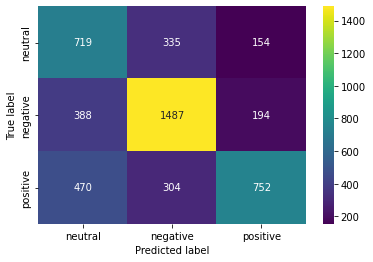

In [7]:
acc,y_true,y_pred=learn.test()
print(f"test acc is {acc*100}%")
cf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Appendix

In [ ]:
import numpy as np
import cv2
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image
import os
from tqdm import tqdm
from PIL import Image
import json
class faceExtractor():
    def __init__(self,rootDir,mode="train",max_num=4) -> None:
        self.root=rootDir
        self.mode=mode
        self.max_num=max_num
        if not os.path.exists(f"{self.root}/FaceDataset"):
          os.mkdir(f"{self.root}/FaceDataset")
        if not os.path.exists(f"{self.root}/FaceDataset/faceImage"):
          os.mkdir(f"{self.root}/FaceDataset/faceImage")
        if not os.path.exists(f"{self.root}/FaceDataset/faceImage/"+mode):
          os.mkdir(f"{self.root}/FaceDataset/faceImage/"+mode)
        # if not os.path.exists(f"{self.root}/FaceDataset/labels"):
        #   os.mkdir(f"{self.root}/FaceDataset/labels")
        self.fault=0
        self.idx_fault=[]
        self.max_len=0
        self.app = FaceAnalysis(providers=['CUDAExecutionProvider', 'CPUExecutionProvider']) # ,allowed_modules=['detection']
        self.Dataset={}
    def run(self,Dataset):
        self.app.prepare(ctx_id=0,det_thresh=0.25,det_size=(640,960))
        index = 0
        for img,dialog,sentiment,idx in tqdm(Dataset):
            faces = self.app.get(img[0])
            img_PIL=Image.fromarray(img[0].astype(np.uint8))
          
            face_count=len(faces)

            if face_count > self.max_len:
              self.max_len = face_count

            if face_count==0:
                self.fault+=1
                self.idx_fault.append(idx)

            else:


              if face_count>self.max_num:
                a = self.max_num
              else :
                a = face_count
              pos=[]
              embedding=[]
              
              for i,f in zip(range(a),faces):
                  pos .append(f['bbox'].tolist()) 
                  embedding.append(f['embedding'].tolist())
              
              self.Dataset[index]={'pos':pos,'embedding':embedding,'text':dialog,'sentiment_cls':sentiment,'size':img[0].shape}
                  # face=img_PIL.crop(f['bbox'])
                  # face.save(f"{self.root}/FaceDataset/faceImage/{self.mode}/"+f'{idx}_{i}.jpg')
              index+=1

        return self.Dataset  


In [ ]:
face_train=faceExtractor(rootDir=".",mode="train")
Dataset_dict=face_train.run(training_data)

with open('/content/drive/MyDrive/train_dataset.json', 'w') as f:
  json.dump(Dataset_dict,f)


In [ ]:
face_test=faceExtractor(rootDir=".",mode="test")
Dataset_dict=face_test.run(test_data)
with open('/content/drive/MyDrive/test_dataset.json', 'w') as f:
  json.dump(Dataset_dict,f)